<a href="https://colab.research.google.com/github/Edenshmuel/PapaJohns_Data_Science_Project/blob/Nadav/Model_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from holidays import country_holidays
import matplotlib.pyplot as plt

In [4]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')

<ipython-input-4-20e4947fae02>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')


In [5]:
desc_encoding_map = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/desc_encoding_map.csv')

In [6]:
# עותק מהנתונים המקוריים
df = cleaned_data.copy()

In [7]:
# שלב 1: הסרת עמודות דגלים
flags_to_remove = ['אחר', 'מנה עיקרית', 'קינוח', 'רוטב', 'שתייה', 'תוספת']
df = df.drop(columns=flags_to_remove)

In [8]:
# שלב 2: הסרת עמודות טקסטואליות/מיותרות
columns_to_drop = ['christian_holiday_name', 'jewish_holiday_name', 'Date', 'order', 'סכום']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [9]:
# שלב 3: יצירת פיצ'ר חדש recent_avg_quantity
df['recent_avg_quantity'] = (
    df
    .groupby('clean_desc_encoded')['כמות']
    .rolling(window=30, min_periods=1)
    .mean()
    .reset_index(0, drop=True))

In [10]:
# שלב 4: הגדרת מטרת החיזוי והפיצ'רים
target = 'כמות'
X = df.drop(columns=[target])
y = df[target]

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [12]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
model_features = X_train.columns.tolist()

In [14]:
def extended_evaluate_model(model, X, y, label='Set'):
    y_pred = model.predict(X)

    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / np.where(y == 0, 1, y))) * 100
    r2 = r2_score(y, y_pred)

    n = X.shape[0]  # num of samples
    k = X.shape[1]  # num of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    print(f'📊 Evaluation on {label}')
    print(f'MAE:  {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'R²:   {r2:.4f}')
    print(f'Adjusted R²: {adj_r2:.4f}')

    return mae, rmse, mape, r2, adj_r2

In [15]:
extended_evaluate_model(model, X_train, y_train, 'Train')
extended_evaluate_model(model, X_val, y_val, 'Validation')
extended_evaluate_model(model, X_test, y_test, 'Test')

📊 Evaluation on Train
MAE:  0.29
RMSE: 0.54
MAPE: 20.32%
R²:   0.4364
Adjusted R²: 0.4364
📊 Evaluation on Validation
MAE:  0.30
RMSE: 0.72
MAPE: 20.61%
R²:   0.2948
Adjusted R²: 0.2945
📊 Evaluation on Test
MAE:  0.29
RMSE: 0.64
MAPE: 20.56%
R²:   0.3778
Adjusted R²: 0.3776


(0.29293137788772583,
 np.float64(0.6352447814051485),
 np.float64(20.56080942295198),
 0.37783199548721313,
 0.3775764629201319)

In [16]:
# בדיקת טווח הערכים של 'כמות'
quantity_min = df['כמות'].min()
quantity_max = df['כמות'].max()
quantity_mean = df['כמות'].mean()
quantity_std = df['כמות'].std()

quantity_min, quantity_max, quantity_mean, quantity_std

(0, 80, np.float64(1.2744951448339046), 0.7637027584396499)

In [17]:
def predict_sales_by_date(forecast_date: str, model, full_df, model_features, desc_map_df):
    # כל הקטגוריות הפעילות
    categories = full_df['clean_desc_encoded'].unique()

    # פרטי התאריך
    date = pd.to_datetime(forecast_date)
    day = date.day
    month = date.month
    year = date.year
    week = date.isocalendar().week
    day_name = ((date.dayofweek + 1) % 7) + 1  # ראשון = 1
    is_weekend = 1 if day_name in [6, 7] else 0

    # מידע על חגים
    il_holidays = country_holidays('IL')
    christian_holidays = country_holidays('US')
    is_jewish_holiday = date in il_holidays
    is_christian_holiday = date in christian_holidays
    is_near_jewish_holiday = ((date + pd.Timedelta(days=1) in il_holidays) or
                              (date - pd.Timedelta(days=1) in il_holidays))
    is_day_before_new_year = 1 if month == 12 and day == 31 else 0
    is_start_of_month = int(day <= 3)
    is_end_of_month = int(day >= 28)
    season = (month % 12) // 3 + 1

    # פיצ'רים מחזוריים
    day_name_sin = np.sin(2 * np.pi * day_name / 7)
    day_name_cos = np.cos(2 * np.pi * day_name / 7)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    # בניית שורות תחזית לכל קטגוריה
    future_rows = []
    for cat in categories:
        recent_avg = full_df[
            (full_df['clean_desc_encoded'] == cat) &
            (pd.to_datetime(full_df['Date']) < date)
        ].sort_values('Date').tail(30)['כמות'].mean()

        row = {
            'Year': year,
            'Month': month,
            'Day': day,
            'WeekOfYear': week,
            'Day_Name': day_name,
            'Is_Weekend': is_weekend,
            'is_jewish_holiday': is_jewish_holiday,
            'is_christian_holiday': is_christian_holiday,
            'is_near_jewish_holiday': is_near_jewish_holiday,
            'is_day_before_new_year': is_day_before_new_year,
            'is_start_of_month': is_start_of_month,
            'is_end_of_month': is_end_of_month,
            'Season': season,
            'Day_Name_sin': day_name_sin,
            'Day_Name_cos': day_name_cos,
            'Month_sin': month_sin,
            'Month_cos': month_cos,
            'clean_desc_encoded': cat,
            'recent_avg_quantity': recent_avg if not np.isnan(recent_avg) else 0,
        }
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)

    # סדר העמודות בהתאם למודל
    future_df = future_df[model_features]

    # תחזית
    future_df['predicted_quantity'] = np.ceil(model.predict(future_df)).astype(int)

    # מיפוי שם קטגוריה
    desc_map_dict = desc_map_df.set_index('code')['Unnamed: 0'].to_dict()
    future_df['category_name'] = future_df['clean_desc_encoded'].map(desc_map_dict)

    return future_df[['category_name', 'predicted_quantity']].sort_values(by='predicted_quantity', ascending=False)

In [28]:
forecast_df = predict_sales_by_date(
    forecast_date='2025-01-03',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

forecast_df.head()

,category_name,predicted_quantity
236,30 קינוח,30
125,10 קלאסיות,10
242,8 טבעות גאודה מצופות,8
245,8 פיצות קלאסיות,8
225,6 גבינות 14,6


In [29]:
future = predict_sales_by_date(
    forecast_date='2025-01-01',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map
)

future2 = predict_sales_by_date(
    forecast_date='2025-01-03',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map
)

# בדוק את השורות עצמן לפני התחזית:
future_inputs_1 = future2.copy()
future_inputs_2 = future.copy()

# השווה בין השורות של שתי התחזיות:
(future_inputs_1.drop(columns=['category_name', 'predicted_quantity'])
 .equals(future_inputs_2.drop(columns=['category_name', 'predicted_quantity'])))

False

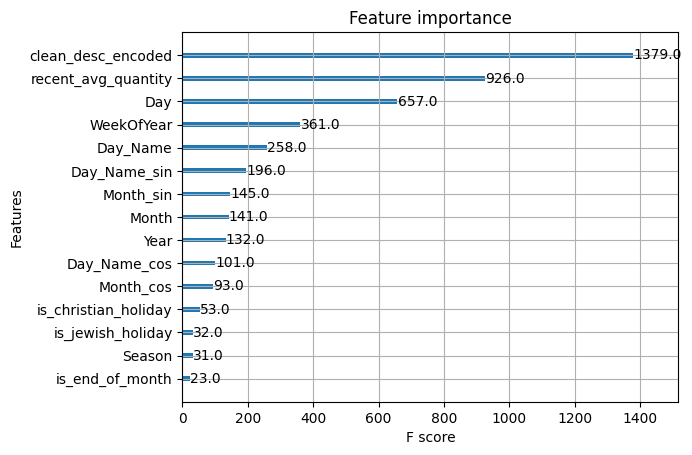

In [22]:
xgb.plot_importance(model, max_num_features=15)
plt.show()

In [19]:
# def generate_future_inputs(forecast_date: str, categories: list):
#     date = pd.to_datetime(forecast_date)
#     day = date.day
#     month = date.month
#     year = date.year
#     week = date.isocalendar().week
#     day_name = ((date.dayofweek + 1) % 7) + 1  # ראשון = 1

#     # תכונות תלויות זמן
#     is_weekend = 1 if day_name in [6, 7] else 0
#     is_jewish_holiday = date in il_holidays
#     is_christian_holiday = date in christian_holidays
#     is_near_jewish_holiday = (
#         (date + pd.Timedelta(days=1) in il_holidays) or
#         (date - pd.Timedelta(days=1) in il_holidays)
#     )
#     is_day_before_new_year = 1 if date.month == 12 and date.day == 31 else 0
#     is_start_of_month = int(day <= 3)
#     is_end_of_month = int(day >= 28)
#     season = (month % 12) // 3 + 1

#     # פיצ’רים מחזוריים
#     day_name_sin = np.sin(2 * np.pi * day_name / 7)
#     day_name_cos = np.cos(2 * np.pi * day_name / 7)
#     month_sin = np.sin(2 * np.pi * month / 12)
#     month_cos = np.cos(2 * np.pi * month / 12)

#     future_rows = []

#     for cat in categories:
#         row = {
#             'Year': year,
#             'Month': month,
#             'Day': day,
#             'WeekOfYear': week,
#             'Day_Name': day_name,
#             'Is_Weekend': is_weekend,
#             'is_jewish_holiday': is_jewish_holiday,
#             'is_christian_holiday': is_christian_holiday,
#             'is_near_jewish_holiday': is_near_jewish_holiday,
#             'is_day_before_new_year': is_day_before_new_year,
#             'is_start_of_month': is_start_of_month,
#             'is_end_of_month': is_end_of_month,
#             'Season': season,
#             'Day_Name_sin': day_name_sin,
#             'Day_Name_cos': day_name_cos,
#             'Month_sin': month_sin,
#             'Month_cos': month_cos,
#             'clean_desc_encoded': cat,
#         }
#         future_rows.append(row)

#     return pd.DataFrame(future_rows)

In [20]:
# def forecast_per_category_for_date(
#     model,
#     df,
#     forecast_date: str,
#     model_features,
#     desc_map_df: pd.DataFrame):

#     categories = df['clean_desc_encoded'].unique()
#     future_df = generate_future_inputs(forecast_date, categories)

#     # התאמה לעמודות המודל בלבד
#     future_df = future_df[[col for col in model_features]]

#     # חיזוי
#     future_df['predicted_quantity'] = np.ceil(model.predict(future_df)).astype(int)

#     # מיפוי שם הקטגוריה
#     desc_map_dict = desc_map_df.set_index('code')['Unnamed: 0'].to_dict()
#     future_df['category_name'] = future_df['clean_desc_encoded'].map(desc_map_dict)

#     return future_df[['category_name', 'clean_desc_encoded', 'predicted_quantity']].sort_values(
#         by='predicted_quantity', ascending=False)

In [21]:
# # דוגמה לשימוש:
# model_features = X_train.columns.tolist()

# forecast_results = forecast_per_category_for_date(
#     model=model,
#     df=df,
#     forecast_date='2025-01-01',
#     model_features=model_features,
#     desc_map_df=desc_encoding_map)

# forecast_results.head()